## A Simple DL Workflow for Binary Classification of Image Data

This is my first image classification kernel in Kaggle, Most of the code is from [a medium article](https://becominghuman.ai/building-an-image-classifier-using-deep-learning-in-python-totally-from-a-beginners-perspective-be8dbaf22dd8) provided in the dataset link, plus I have also tried to document the flow so that anyone can understand code and theory side by side. For the theoretical explanations, I have referred to [Deep Learning with Python Book](https://www.manning.com/books/deep-learning-with-python) and some online articles as and when required.

I have used data on Cats and Dogs Images as a toy dataset for the demonstration.

#### Pre-requisites: 
- Working knowledge of ANNs
- A high level idea about what CNNs are and willingness to explore further details.

I have also tried to run some experiments by changing parameters, but due to slow execution time in the kernel, its limited.

### Overall the workflow has the following steps.

1. Loading required libraries
2. Specifying the components of the Sequential Classifier (CNN Model)
3. Load Training and Test data, also perform data augmentation
4. Fit the model and obtain results.

Hope some beginners in the field of DL and Image Processing will find it useful!

### What is a CNN model and why is it useful for image classification?

I won't go into the gory mathematical details, if interested there are many resources available in form of books (e.g. [Deep Learning Book](http://www.deeplearningbook.org/)) or online blogs.

The USP of the CNN modelling technique is the *convolution* operation.

> Dense networks learn global patterns in their input feature space, whereas convolutions learn local patterns. This is very useful when learning patterns in images.

#### Two interesting properties of convnets are as follows:

* *The patterns they learn are translation invariant* which simply means that after learning a pattern in the lower-right corner of a picture, a convnet can recognize the same anywhere in the example, in contrast a densely connected network will have to learn the pattern anew if it came up at a new location.

* *They can learn spatial hierarchies of patterns* implying that the 1st convolution will learn small local patterns, second will learn larger patterns using the first layer and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts which is how the visual world behaves too. A simple example to illustrate this will be: in case a the network is trying to learn human facial expressions, the first layer can learn the edges around ears, nose etc, the second layer will recognize the organs themselves and so on.

### Loading required libraries

In [21]:
from keras.models import Sequential                             # To specify a sequential model. 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense   # Components of the CNN model, we will cover them in details later.
from keras.preprocessing.image import ImageDataGenerator        # To load image data and augment it with more examples.

# General purpose tools.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Specifying the components of the Sequential Classifier (CNN Model)

As we are using a sequential CNN model, we will initialize the classifier as Sequential()

In [2]:
classifier = Sequential()

Image is a 2D Convnet so we can use Conv2D function to add the parameters for the first layer. We have specify the input layer dimensions as well as this is the first layer.

Some input options for the Conv2D function are described as follows (there are others too, but I am covering only the commonly used ones):

* *filters* - they encode a specific aspect of the input data, for instance "presence of a tree in a picture". Common values are 32 or 64. 
* *kernel_size* - size of the patches which we would perform the convolution operation on the matrix with. Commonly used values are (3,3) or (5,5).
* *strides* - size of the stride that is taken after every convolution operation, defaults to (1,1) which we will be using. This reduces the size of the matrix if a value > 1 is used, so must be applied with caution.
* *padding* - if we want to preserve the size of the input array, we can change the value of this parameter to "same", otherwise defaults to "valid" which means no padding.
* *activation* - the activation function to used for this network layer, we will use REctified Linear Unit (or ReLU), complete list of activation functions available in keras can be found [here](https://keras.io/activations/).
* *input_shape* - shape of the input feature maps (3D tensors), we will use height = width = 64 and no. of channels = 3 since we have color (RGB) images.

In [3]:
classifier.add(
    Conv2D( 32, (3,3),
           input_shape = (64, 64, 3),
           activation = 'relu')
)

Most of the times while building CNN, previous Conv2D operations might increase the number of parameters exponentailly which will increase the time and resources required for training, so it makes sense to use an operation which can reduce parameters but at the same time preserve the important information learned in the previous layers. This is where the Max Pooling operation comes in the picture. It is used to agressively downsample the feature maps.

It consists of extracting windows from the input feature maps and outputting the max value of each channel (in our case we choose window/pool size = 2,2

> An alternative to this is Avg Pooling, but this has been found to work better in practice.

In [4]:
classifier.add(
    MaxPooling2D(
        pool_size = (2,2)
    )
)

Depending on your problem, amount of input data, available computational resources etc., one can choose to add more Conv2D and Pooling layers successively, but in this demo we will stop here :)

Once we are done with building the layers, we will have to convert this 2D data to 1D since the output layer will process that to furnish the final results. This is achieved by flattening the last layer.

In [5]:
classifier.add(Flatten())

To the flattened layer we add another dense layer with a ReLU activation function to reduce the size.

In [6]:
classifier.add(
    Dense(
        units = 128, 
        activation = 'relu'
    )
)

Since this is binary classification problem, we will need the final output in form of a probability, because of which we will add the final layer with 1 unit and sigmoid activation function.

> In case of multi-class classification problem (with *m* classes) we can use (m-1) units and softmax activation function.

In [7]:
classifier.add(
    Dense(
        units = 1, 
        activation = 'sigmoid'
    )
)

Now our CNN is almost ready, the penultimate step before using it, is to specify some important modelling parameters:

* *optimizer* - the optimization method used during learning. We will use adaptive momentum (adam) optimizer, full list is available [here](https://keras.io/optimizers/).
* *loss* - loss function used in the learning process. Since this is a binary classification problem, we should use 'binary_crossentropy', other options are listed [here](https://keras.io/losses/).
* *metrics* - the metrics that we will optimize for, we can use accuracy, mse, etc. or a combination of multiple metrics.

In [8]:
classifier.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

We can take a quick look of the complete network by using the summary() function.

In [9]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,937,409
Trainable params: 3,937,409
Non-trainable params: 0
_________________________________________________________________


### Load Training and Test data, also perform data augmentation

We observe that the training data set contains about 8000 images, this is a very less amount of data for a deep learning technique to be able to build a robust model. This is a common problem in many image processing projects too which if not addressed properly might lead to a lot of overfitting.

*Data Augmentation* is a common method used to synthetically increase the size of your dataset while adding relevant data. What it simply does is, it takes various snapshots of a given image in the data set and applies various transformations randomly to get more data. This helps us increase the training and validation data size and address the issue of overfitting.

The **ImageDataGenerator** is used for this purpose and has the following arguments:
* *rotation_range* - is a value in degrees (0-180), range withing which to randomly rotate pictures.
* *width_shift* and *height_shift* - are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* *shear_range* - is for randomly applying shearing transformations
* *zoom_range* - is for randomly zooming inside pictures
* *horizontal_flip* - is for randomly flipping half of the images horizontaly. Assuming no horizontal assymetry.

> There are other arguments too, but the above ones are the most commonly used.

In [10]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
training_set = train_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size = (64,64),
    batch_size = 32,
    class_mode = 'binary'
)

Found 8005 images belonging to 2 classes.


In [12]:
test_set = test_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/test_set/test_set',
    target_size = (64,64),
    batch_size = 32,
    class_mode = 'binary'
)

Found 2023 images belonging to 2 classes.


### Fit the model and obtain results.

We will finally fit a model to the data using the **fit_generator** function. Some important arguments of which are explained as follows:

* *generator* - the generator function for training data.
* *steps_per_epoch* - number of images to be considered during each pass of the training set generator.
* *epochs* - number of epochs to be run. An epoch is an iteration over the entire data provided.
* *validation_data* - validation data generator
* *validation_steps* - number of images to consider from the test data in each epoch.

> NOTE: We use low values for most parameters because higher values will lead to very high computational time, in a real world setting it would make more sense to use more computational resources to build models faster. 

We store the results in a variable so that we can use it for further analysis (if required)

In [14]:
history = classifier.fit_generator(
    training_set,
    steps_per_epoch = 2500,
    epochs = 5,
    validation_data = test_set,
    validation_steps = 1000
)

Epoch 1/5
2500/2500 [==============================] - 469s 188ms/step - loss: 0.2718 - accuracy: 0.8833 - val_loss: 1.0540 - val_accuracy: 0.7601
Epoch 2/5
2500/2500 [==============================] - 468s 187ms/step - loss: 0.1910 - accuracy: 0.9238 - val_loss: 0.6189 - val_accuracy: 0.7609
Epoch 3/5
2500/2500 [==============================] - 465s 186ms/step - loss: 0.1422 - accuracy: 0.9450 - val_loss: 1.2956 - val_accuracy: 0.7680
Epoch 4/5
2500/2500 [==============================] - 464s 186ms/step - loss: 0.1101 - accuracy: 0.9585 - val_loss: 1.2261 - val_accuracy: 0.7562
Epoch 5/5
2500/2500 [==============================] - 459s 183ms/step - loss: 0.0855 - accuracy: 0.9687 - val_loss: 1.9419 - val_accuracy: 0.7467


It is a good practice to save a classifier/model once we have completed building it. 

In [15]:
classifier.save('cats_and_dogs_classifier_1.h5')

Finally, we plot the evolution of the optimizing metric and loss value over all epochs to understand how the model did.

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<Figure size 432x288 with 0 Axes>

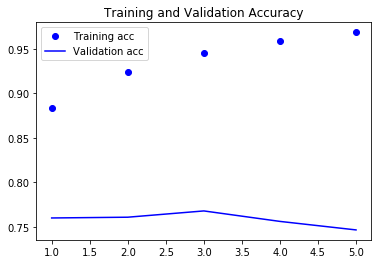

<Figure size 432x288 with 0 Axes>

In [22]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

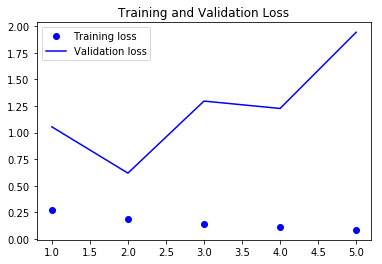

In [23]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

As we can see above, our model doesn't give good performance mainly due to the fact that we didn't use more data and more epochs to train it, currently the model does a lot of over-fitting since the training metrics improve but the validation doesn't.

Nonetheless I hope this kernel will give you a good idea about how the CNN model works in practice for binary image classification.

If you went through the trouble of going through this notebook, thanks for your time :)
Will welcome comments and suggestions to imporove this further!